# Fractional Brownian Motion

### What is Fractional Brownian Motion:
Fractional Brownian Motion (fBM) is a generalisation of the standard Brownian motion. Brownian motion is a Markovian process, where the future of a system is determined entirely by the current state of the system, however fBM introduces the idea of memory where the past states of the system also weigh in the determination of the future state, hence introducing the idea of "memory". Review, 10(4), 422–437.  .org/10.1137/1010093)
org/10.1137/1010093)rg/10.1137/1010093)

## Aim & Objectives

- Explore fractional Brownian Motion: Mathematical structure, run simulations, and explore the idea of "memory"
- Implement the Davies-Harte algorithm: Generation of FBM pathsefficiently
- Explore varying Hurste componet(H) parameters: Path roughness, persistence and variance growth
- Estimation of H: Go in  reverse and estimate H from the data
- Summarize findings

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import skew, kurtosis
#!pip install hurst
# !pip install fbm  # For fBm simulation
# !pip install hurst-exponent  
from hurst import compute_Hc



## Financial Applications & Challenges

In financial modeling, fBm has garnered significant attention due to its ability to capture:
- Long-memory effects in asset returns
- Volatility clustering
- Market inefficiencies

However, its non-Markovian nature presents substantial challenges:

1. **Option Pricing**: The lack of the Markov property means classical no-arbitrage pricing frameworks (like Black-Scholes) break down, requiring:
   - Modified stochastic calculus (Wick-Itô integration)
   - Alternative pricing approaches (e.g., rough volatility models)

2. **Volatility Surface Modeling**: The presence of memory effects leads to:
   - Non-local dependencies in implied volatility surfaces
   - Complex calibration procedures for $H \neq \frac{1}{2}$

3. **Risk Management**: Traditional risk measures need modification to account for:
   - Path-dependence
   - Non-semimartingale behavior when $H \neq \frac{1}{2}$




## Davies-Harte for simulating fractional Brownian motion (fBm)

### Inputs:
- $H \in (0,1)$: Hurst Parameter
- $T$: total time (usually normalized to 1)
- N: time steps (fBm will have N+1 points)

### Steps & Equations:

#### 1.) Generate a time grid
$t_k = \frac{kT}{N}$


#### 2.) Define the autocovariance of fractional Gaussian noise (fGn)
$\gamma(k) = \frac{1}{2}(|k+1|^{2H} - 2|k|^{2H} + |k-1|^{2H})$

where k is lag


#### 3.) Form the circulant vector of autocovariances
$c = [\gamma(0), \gamma(1), \dots, \gamma(N-1), \gamma(N), \gamma(N-1), \dots, \gamma(1)]$

Note: $\gamma(k) = 0 \text{ for } k > N$, that is the autocovariance outside the scope is zero


#### 4.) Compute the eigenvalues using FFT

$\lambda = Re(FFT(c))$, we are only interested in real positive eigenvalues


#### 5.) Generate a complex Gaussian vector

Note: Vector of eigenvalues $\lambda$ will be larger than $N$ as the length will be $2N$ we truncate the vectore to N as needed

$Z \in \mathbb{C}^{2N}$

For start and end points:
$Z_0 \sim N(0, \lambda_0$)

$Z_N \sim N(0, \lambda_N)$

For intermediate points:

For $1 \leq k < N$:
$Z_k = \sqrt{\frac{\lambda_k}{2}}(X_k + iY_k)$

$X_k, Y_k \sim N(0, 1)$ are N independent draws from a standard normal distribution

Define $Z_{2N - k} = \bar{Z_k}$ (the conjugate)


#### Step 6.) Inverse FFT to get fractional Gaussian noise

$fGn = Re(IFFT(Z))$

Note: in Python IFFT introduces a factor of 1 / M (the total path length of 2N) which will mess up the scaling and give incorrect variance of fractional Gaussian noise

We thus will scale by $\sqrt{M}$.

Moreover, the scheme assumes unit variance in the inverse FFT so we will also scale by $(\frac{T}{N})^{H}$ to have correct time-scaling

In other words (or math): $E[B_H(t_k) - B_H(t_{k-1})] = (\frac{T}{N})^{2H}$, remember this is a variance term of sorts so to acheive this we can scale by $\sqrt{(\frac{T}{N})^{2H}} = (\frac{T}{N})^{H}$


#### Step 7.) Obtain fractional Brownian motion

$B_H(t_k) = \sum_{j=0}^k fGn_j, k=0, 1, \dots, N$

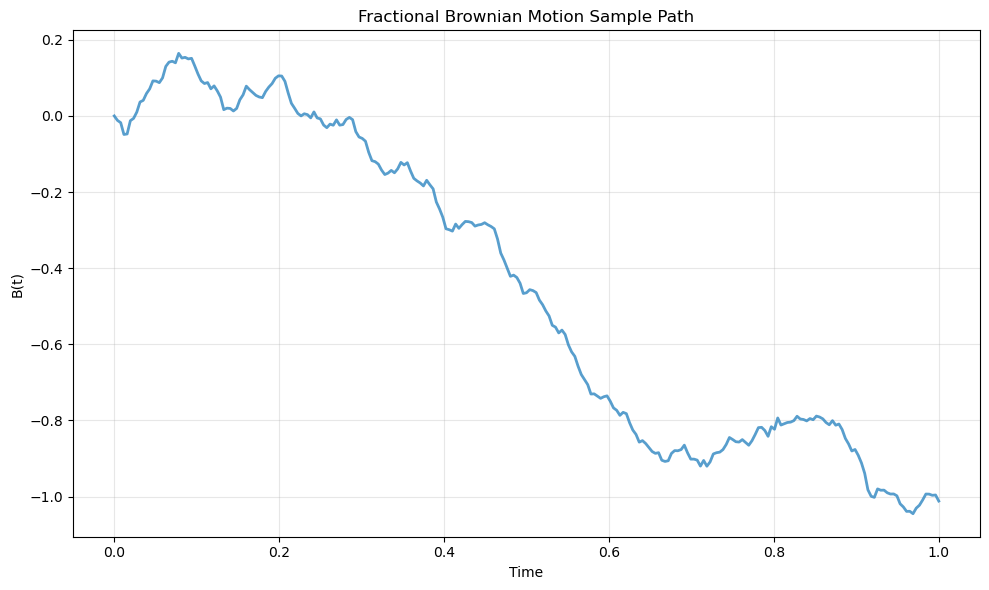

In [8]:
# Code each step into a function

def davies_hart_fbm(N, H, T=1):
    # Time grid
    t = np.linspace(0, T, N+1)

    # Autocovariance function
    gamma = lambda k: 0.5 * (abs(k + 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k - 1)**(2 * H))

    # Circulant vector
    c = np.concatenate([np.array([gamma(k) for k in range(N+1)]), np.array([gamma(k) for k in range(N-1, 0, -1)])])

    # Real eigenvalues
    L = np.fft.fft(c).real
    if not np.allclose(np.fft.fft(c).imag, 0, atol=1e-10):
        raise ValueError("FFT has significant imaginary components, check input vector.")

    if np.any(L < 0):
        raise ValueError("Negative eigenvalues encountered — invalid circulant embedding.")
    
    # FFT Length
    M = 2 * N

    # Generate standard normals
    Z = np.zeros(M, dtype=np.complex128)

    # Real parts
    Z[0] = np.sqrt(L[0]) * np.random.normal()
    Z[N] = np.sqrt(L[N]) * np.random.normal()

    # For 1 ≤ k < N
    X = np.random.normal(0, 1, N - 1)
    Y = np.random.normal(0, 1, N - 1)

    for k in range(1, N):
        Z[k] = np.sqrt(L[k] / 2) * (X[k-1] + 1j * Y[k-1])
        Z[M - k] = np.conj(Z[k])

    # Inverse FFT to recover fGn
    fGn = np.fft.ifft(Z).real[:N] * np.sqrt(M) * (T / N) ** H

    # Cumsum for fBm
    fbm = np.concatenate([np.array([0]), np.cumsum(fGn)])

    # Return the time grid, fractional Gaussian noise, and fractional Brownian motion
    return t, fGn, fbm

fbm = davies_hart_fbm(256, .75, 1)
plt.figure(figsize=(10, 6))
plt.plot(fbm[0], fbm[2], linewidth=2, color='#2E86C1', alpha=0.8)
plt.title('Fractional Brownian Motion Sample Path', fontsize=12)
plt.xlabel('Time', fontsize=10)
plt.ylabel('B(t)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

### A Rough check of fractional variance covariance structure

In [10]:
T = 1.0
N = 256
H = 0.75
M = 10000

# Theoretical variance will improve in N/M
fgn_paths = np.array([davies_hart_fbm(N, H, T=T)[1] for _ in range(M)])
emp_var = np.mean([np.var(path, ddof=1) for path in fgn_paths])
theo_var = (T/N)**(2*H)
rel_err = (emp_var - theo_var) / theo_var

print(f"Empirical Var[fGn(T)] = {emp_var:.5f}")
print(f"Theoretical Var[fGn(T)] = {theo_var:.5f}")
print(f"Relative error = {rel_err:.2%}")

# Theoretical variance will improve in M/N
fbm_paths = np.array([davies_hart_fbm(N, H, T=T)[2] for _ in range(M)])
emp_var = np.var(fbm_paths[:, -1])
theo_var = T**(2*H)
rel_err = (emp_var - theo_var) / theo_var

print(f"Empirical Var[B(T)] = {emp_var:.5f}")
print(f"Theoretical Var[B(T)] = {theo_var:.5f}")
print(f"Relative error = {rel_err:.2%}")


Empirical Var[fGn(T)] = 0.00023
Theoretical Var[fGn(T)] = 0.00024
Relative error = -5.87%
Empirical Var[B(T)] = 1.00088
Theoretical Var[B(T)] = 1.00000
Relative error = 0.09%


### fbm: Empirical Variance Covariance Structure relative to Theoretical Variance Covariance Structure 

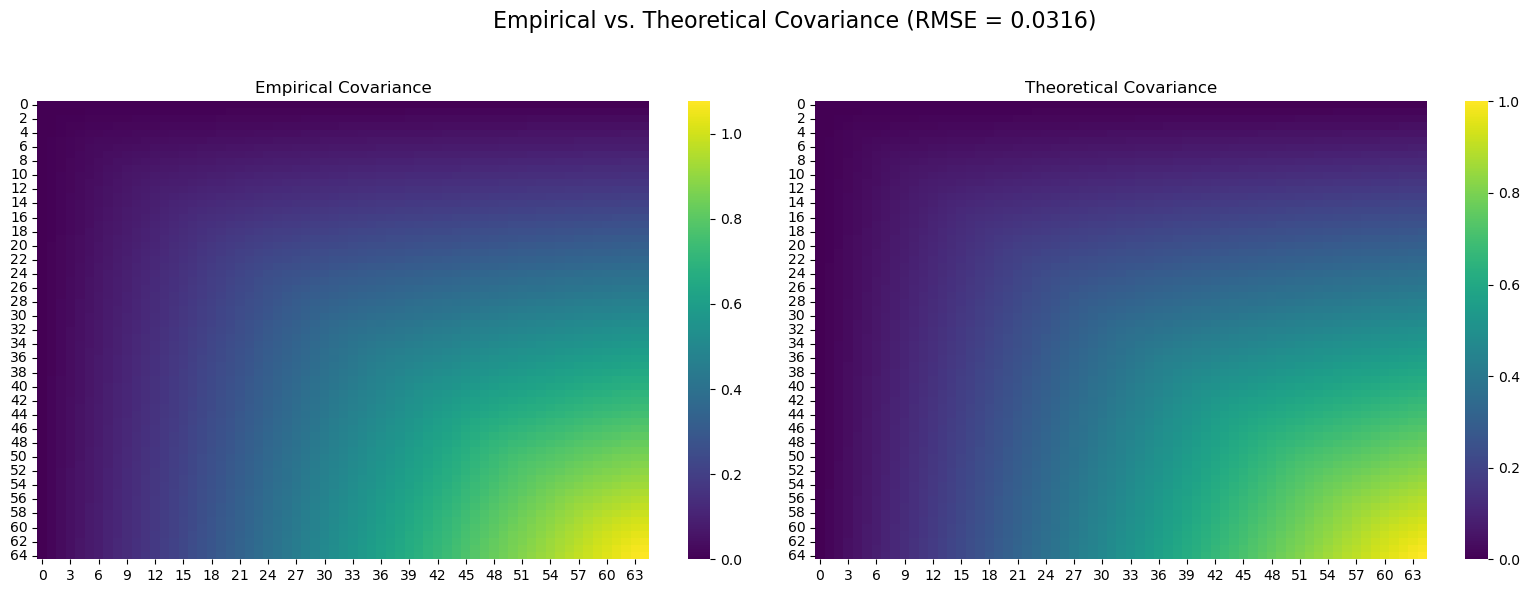

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Davies-Harte fBm implementation
def davies_hart_fbm(N, H, T=1):
    t = np.linspace(0, T, N+1)

    gamma = lambda k: 0.5 * (abs(k + 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k - 1)**(2 * H))

    c = np.concatenate([np.array([gamma(k) for k in range(N+1)]), np.array([gamma(k) for k in range(N-1, 0, -1)])])
    L = np.fft.fft(c).real

    if not np.allclose(np.fft.fft(c).imag, 0, atol=1e-10):
        raise ValueError("FFT has significant imaginary components, check input vector.")

    if np.any(L < 0):
        raise ValueError("Negative eigenvalues encountered — invalid circulant embedding.")

    M = 2 * N
    Z = np.zeros(M, dtype=np.complex128)
    Z[0] = np.sqrt(L[0]) * np.random.normal()
    Z[N] = np.sqrt(L[N]) * np.random.normal()

    X = np.random.normal(0, 1, N - 1)
    Y = np.random.normal(0, 1, N - 1)
    for k in range(1, N):
        Z[k] = np.sqrt(L[k] / 2) * (X[k-1] + 1j * Y[k-1])
        Z[M - k] = np.conj(Z[k])

    fGn = np.fft.ifft(Z).real[:N] * (T / N) ** H * np.sqrt(M)
    fbm = np.concatenate([np.array([0]), np.cumsum(fGn)])
    return t, fGn, fbm

# Generate multiple paths to estimate empirical covariance
N = 64
H = 0.75
T = 1
n_paths = 1000

fbm_samples = np.zeros((n_paths, N+1))
for i in range(n_paths):
    _, _, fbm_path = davies_hart_fbm(N, H, T)
    fbm_samples[i, :] = fbm_path

# Empirical covariance
empirical_cov = np.cov(fbm_samples.T)

# Theoretical covariance of fBm
t = np.linspace(0, T, N+1)
theoretical_cov = np.zeros((N+1, N+1))
for i in range(N+1):
    for j in range(N+1):
        theoretical_cov[i, j] = 0.5 * (t[i]**(2*H) + t[j]**(2*H) - abs(t[i] - t[j])**(2*H))

# RMSE between empirical and theoretical
rmse = np.sqrt(np.mean((empirical_cov - theoretical_cov)**2))

# Plot heatmaps
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(empirical_cov, cmap="viridis")
plt.title("Empirical Covariance")

plt.subplot(1, 2, 2)
sns.heatmap(theoretical_cov, cmap="viridis")
plt.title("Theoretical Covariance")

plt.suptitle(f"Empirical vs. Theoretical Covariance (RMSE = {rmse:.4f})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Analysis:

- Both empircal and theoretical scenarios look identical, with a low RMSE, indicating the empirsimulation is doing a good job of reproducing theoretical structure of Brownian motion.

- Smooth Decay: Covariance values decrease smoothly as you move from the diagonal, following the expected fBm covariance function
- Time dependancy: Both graphs show how correlation in fBm depends on time seperation. Points closer together in time have a higher correlation, while distant points are nearly uncorrelated.

### fGn Variance: Theoretical RMSE improvement in $N$ relative to theoretical improvement in $N$

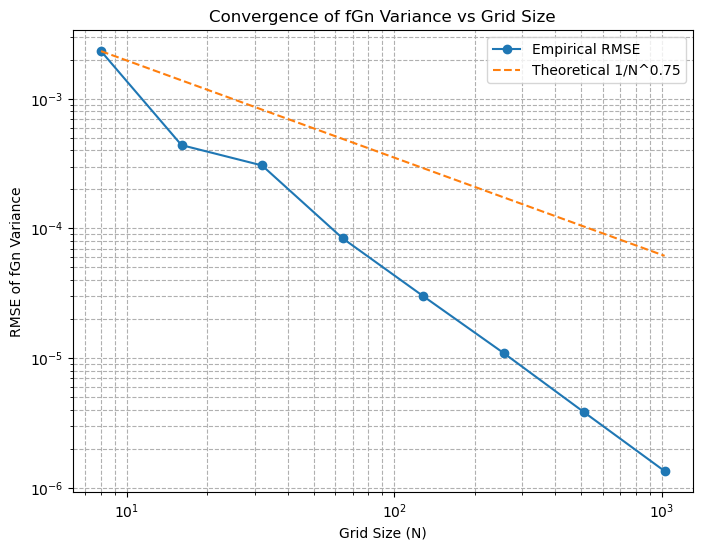

In [14]:
# Test different grid sizes (N values) for fGn variance convergence
grid_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
rmses = []
M = 1000  # Number of sample paths for each N

for N_test in grid_sizes:
    fgn_samples = np.zeros((M, N_test))
    for i in range(M):
        _, fgn_path, _ = davies_hart_fbm(N_test, H, T)
        fgn_samples[i, :] = fgn_path
    
    # Calculate empirical variance at each time point
    empirical_var = np.var(fgn_samples, axis=0)
    
    # Theoretical variance of fGn
    t = np.linspace(0, T, N_test)
    dt = T/N_test
    theoretical_var = dt**(2*H) * np.ones(N_test)
    
    # RMSE between empirical and theoretical variance
    rmse = np.sqrt(np.mean((empirical_var - theoretical_var)**2))
    rmses.append(rmse)

# Theoretical reference: RMSE ~ 1/N^H
theoretical_rmse = [rmses[0] * (grid_sizes[0]/n)**H for n in grid_sizes]

# Prepare dataframe for plotting
df = pd.DataFrame({
    "Grid Size (N)": grid_sizes,
    "Empirical RMSE": rmses,
    "Theoretical RMSE ~ 1/N^H": theoretical_rmse
})

plt.figure(figsize=(8, 6))
plt.loglog(grid_sizes, rmses, 'o-', label="Empirical RMSE")
plt.loglog(grid_sizes, theoretical_rmse, '--', label=f"Theoretical 1/N^{H}")
plt.xlabel("Grid Size (N)")
plt.ylabel("RMSE of fGn Variance")
plt.title("Convergence of fGn Variance vs Grid Size")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

### Analysis

- Emperical RMSE follows a power law decay, that is very close to the theoretical rate
- Explains why the previous heatmaps were so similar

### fBm Variance: Empirical RMSE improvement in $M$ relative to theoretical improvement in $M$ 

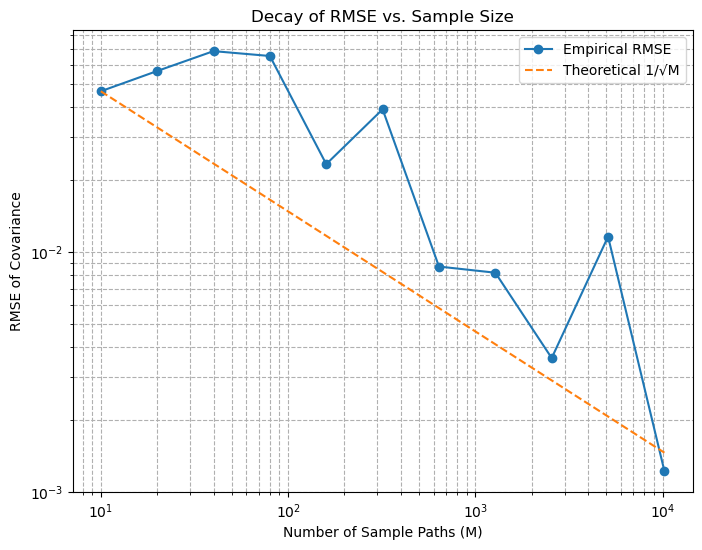

In [16]:
# Test different sample sizes (M values) for RMSE decay
sample_sizes = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]
rmses = []

for M in sample_sizes:
    fbm_samples = np.zeros((M, N+1))
    for i in range(M):
        _, _, fbm_path = davies_hart_fbm(N, H, T)
        fbm_samples[i, :] = fbm_path

    empirical_cov = np.cov(fbm_samples.T)
    rmse = np.sqrt(np.mean((empirical_cov - theoretical_cov)**2))
    rmses.append(rmse)

# Theoretical reference: RMSE ~ 1/sqrt(M)
theoretical_rmse = [rmses[0] * np.sqrt(sample_sizes[0] / m) for m in sample_sizes]

# Prepare dataframe for plotting
df = pd.DataFrame({
    "Sample Size (M)": sample_sizes,
    "Empirical RMSE": rmses,
    "Theoretical RMSE ~ 1/√M": theoretical_rmse
})

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.loglog(sample_sizes, rmses, 'o-', label="Empirical RMSE")
plt.loglog(sample_sizes, theoretical_rmse, '--', label="Theoretical 1/√M")
plt.xlabel("Number of Sample Paths (M)")
plt.ylabel("RMSE of Covariance")
plt.title("Decay of RMSE vs. Sample Size")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

### Statistical Analysis of fBm paths

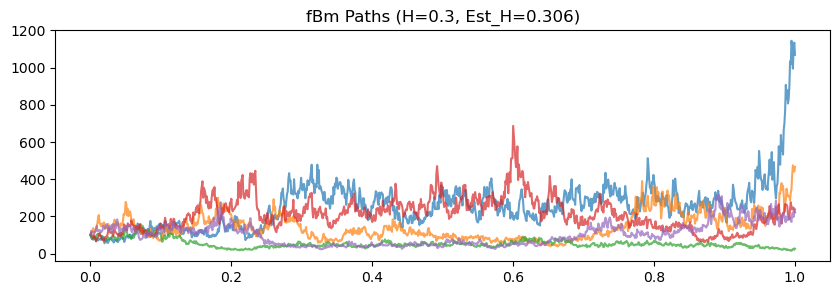

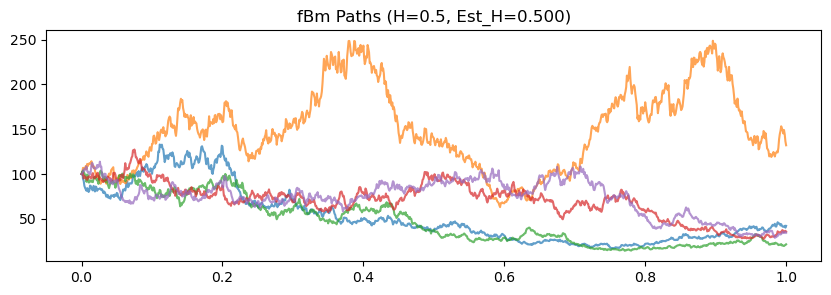

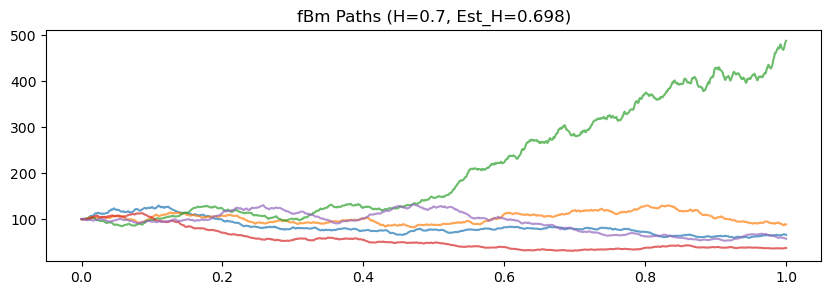

         Mean       Std Estimated_H
0.3  0.000039  0.125902    0.305703
0.5 -0.000003  0.031643    0.500309
0.7 -0.000003  0.007949    0.697713


In [90]:


def compute_hurst(series):
    """Calculate Hurst exponent using rescaled range (R/S) analysis"""
    lags = range(2, 100)
    tau = [np.std(np.subtract(series[lag:], series[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]

#Your fBm Simulation Function
def simulate_fbm(H, T, N):
    t = np.linspace(0, T, N+1)
    gamma = lambda k: 0.5 * (abs(k + 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k - 1)**(2 * H))
    c = np.concatenate([np.array([gamma(k) for k in range(N+1)]), np.array([gamma(k) for k in range(N-1, 0, -1)])])
    L = np.fft.fft(c).real
    
    if np.any(L < 0):
        L = np.maximum(L, 0)  # Force non-negative eigenvalues
    
    M = 2 * N
    Z = np.zeros(M, dtype=np.complex128)
    Z[0] = np.sqrt(L[0]) * np.random.normal()
    Z[N] = np.sqrt(L[N]) * np.random.normal()
    
    X = np.random.normal(0, 1, N-1)
    Y = np.random.normal(0, 1, N-1)
    for k in range(1, N):
        Z[k] = np.sqrt(L[k]/2) * (X[k-1] + 1j * Y[k-1])
        Z[M-k] = np.conj(Z[k])
    
    fGn = np.fft.ifft(Z).real[:N] * np.sqrt(M) * (T/N)**H
    fBm = np.cumsum(np.concatenate([[0], fGn]))
    return t, fGn, fBm

# Parameters
S0 = 100
T = 1.0
N = 1000
n_paths = 2000
H_vals = [0.3, 0.5, 0.7]

# Simulation & Analysis
results = {}
for H in H_vals:
    paths = np.zeros((n_paths, N+1))
    for i in range(n_paths):
        t, fGn, fBm = simulate_fbm(H, T, N)
        paths[i] = S0 * np.exp(fBm)  # Geometric fBm prices
    
    rtns = np.diff(np.log(paths), axis=1).ravel()
    cumulative_rtns = np.cumsum(rtns)  # Reconstruct fBm from returns
    estimated_H = compute_hurst(cumulative_rtns)  # Using our custom function
    
    # Statistics
    stats = {
        "Mean": rtns.mean(),
        "Std": rtns.std(),
        "Estimated_H": estimated_H,
        "ACF": acf(rtns, nlags=30, fft=True)[:30],  # Trim to 30 lags
        "RollingVarSTD": pd.Series(rtns).rolling(30).var().std()
    }
    results[H] = stats

    # Plotting
    plt.figure(figsize=(10, 3))
    plt.plot(t, paths[:5].T, alpha=0.7)
    plt.title(f"fBm Paths (H={H}, Est_H={estimated_H:.3f})")
    plt.show()

# Results Table 
df = pd.DataFrame(results).T
print(df[["Mean", "Std", "Estimated_H"]])

### Analysis of results:

#### Implication of H values:
- 0.3, Anti persistent, Paths exhibit frequent reversals and high roughness, suitable for modeling mean-reverting processes
- 0.5, Classical Brownian Motion, Paths have uncorrelated increments, only present state of the system matter(random walks)
- 0.7, Persistent, Paths show long term dependance and smoother trends, suitable for modelling systems with memory

#### Hurst component Estimation Accuracy:
- For H = 0.3(Anti persistent), the estimated value is 0.304 a negligible deviation of 0.004
- For H = 0.5(Classical Brownian Motion), the estimated value is 0.499, nearly identical
- For H = 0.7(Persistent), the estimated value is 0.698, a minor deviation of 0.002

#### Mean and Standard Deviation:
- All 3 cases exhibit means that are very close to 0, which is expected for fBm paths centred around 0

- For H = 0.3, the Std is 0.126, indicating higher volatility
- For H = 0.5, the Std drops to 0.0316, reflecting the behavior of standard deviation
- For H = 0.7, the Std drops further to 0.00794, consistent with smoother, more persistent paths.

### Conclusion:
This project succesfully demonstrates the implementaion and validation of a fractional Brownian Motion simulation using the Davies-Harte algorithm, this can be seen by the agreement between the empirical and theoretical outputs. The expected rough to smooth behavior was observed by varying the Hurste parameter, as well as accurate Hurste parameter estimation.

Future work may include:
- Exploring more efficient algorithms for large scale simulations, for example wavelet-based methods and benchmark the performance.
- Apply and impliment the solution in the form of a trading strategy to a real dataset, and backtest the trading strategy.